In [1]:
import numpy as np
import sympy.matrices
from sympy import init_session
import matplotlib.pyplot as plt
import scipy

init_session()
h = sympy.Symbol('h')
x = sympy.Symbol('x')
v = sympy.Symbol('v')

%matplotlib inline

IPython console for SymPy 1.10.1 (Python 3.9.13-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.10.1/



## 1. Pseudo-Hamiltonian for SHO

$$
\tilde{H}(h) = \dfrac{1}{2}x^2+\dfrac{1}{2}v^2\dfrac{1}{1-\dfrac{h^2}{4}}
$$

### a. Use the Jacobian for the Leapfrog method

First, we have the Jacobian matrix for the Leapfrog method:

In [35]:
def J_leapfrog(h):
    a = sympy.matrices.Matrix([[1,0],[-h/2,1]])
    b = sympy.matrices.Matrix([[1,h],[0,1]])
    return a*b*a

def H(x, v, h):
    return 0.5*x**2 + 0.5*v**2*(1/(1-h**2/4))

pprint(sympy.simplify(J_leapfrog(h)))

⎡     2        ⎤
⎢    h         ⎥
⎢1 - ──    h   ⎥
⎢    2         ⎥
⎢              ⎥
⎢ 3           2⎥
⎢h           h ⎥
⎢── - h  1 - ──⎥
⎣4           2 ⎦


Now, check whether the pseudo-Hamiltonian is **conserved** by doing:

$$
\begin{bmatrix}
x_{n+1}\\
v_{n+1}\\
\end{bmatrix}
= J
\begin{bmatrix}
x_n\\
v_n\\
\end{bmatrix}
$$

and then calculating pseudo-Hamiltonian with both vectors. We should find no difference.

$$
\tilde{H}\begin{bmatrix}
x_{n+1}\\
v_{n+1}\\
\end{bmatrix} = \tilde{H}\begin{bmatrix}
x_n\\
v_{n}\\
\end{bmatrix}
$$

showing that $\tilde{H}$ is conserved. 

In [4]:
xv = sympy.matrices.Matrix([x, v])
x_new, v_new = sympy.simplify(J_leapfrog(h) * xv)

#compute hamiltonian
H_xv = H(x, v, h)
H_xv_new = H(x_new, v_new, h)

#pprint(H_xv) 
#pprint(H_xv_new)

pprint(sympy.simplify(H_xv - H_xv_new))

0


The above shows thay $\tilde{H}$ is conserved using the Leapfrog method.


### b. Numerical implementation of leapfrog method for SHO

In [36]:
def pseudo_H(x, v, h):
    return 0.5*x**2 + 0.5*v**2*(1/(1-h**2/4))


def leapfrog(nsteps, h, x0, v0):
    x = np.zeros(nsteps+1)
    v = np.zeros(nsteps+1)
    E = np.zeros(nsteps+1)
    
    x[0] = x0
    v[0] = v0
    E[0] = pseudo_H(x0, v0, h)
    
    for i in range(1, nsteps+1):
        #leapfrog steps
        # n = i-1 -> n+1 = i
        a = -x[i-1]
        v12 = v[i-1] + a*h/2
        x[i] = x[i-1] + h*v12
        a = -x[i] #update acceleration
        v[i] = v12 + (h/2)*a
        
        #energy is given by pseudo-Hamiltonian
        E[i] = pseudo_H(x[i], v[i], h)
    
    return x, v, E

Initial energy =  0.5
Final energy =  0.4999999999999991


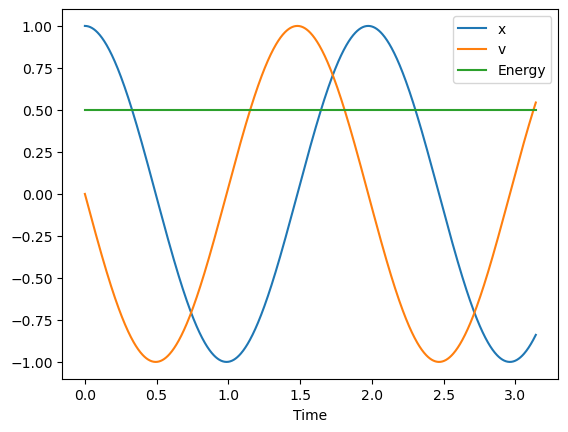

Text(0, 0.5, '$\\dfrac{E-E_0}{E}$')

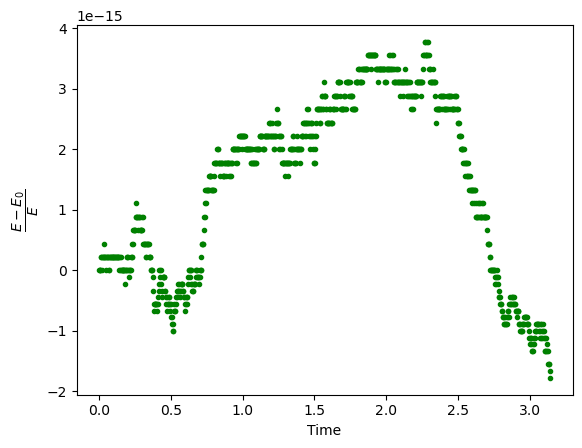

In [44]:
nsteps = 1000
dt = 1e-2
t = np.linspace(0, np.pi, nsteps+1)
x, v, E = leapfrog(nsteps, dt, 1., 0.)

print('Initial energy = ', E[0])
print('Final energy = ', E[-1])


plt.plot(t, x, label='x')
plt.plot(t, v, label='v')
plt.xlabel('Time')
plt.plot(t, E, label='Energy')
plt.legend()
plt.show()

plt.plot(t, (E-E[0])/E, '.', color='Green')
plt.xlabel('Time')
plt.ylabel('$\dfrac{E-E_0}{E}$')

The plot above shows the expected oscillatory behaviour for x and v for a simple hermonic oscillator.

Additionally, it demonstrates numerically that energy, given by the pseudo Hamiltonian $\tilde{H}$, is conserved. 

### c. Scaling of enery error

In [162]:
N = np.logspace(0,6,20)
E_half = []

#half-cycle
for n in N:
    dt = (np.pi)/n
    x, v, E = leapfrog(int(n), dt, 1., 0.)
    E_real = 0.5*(x**2 + v**2)
    error = (E_real[-1]-E_real[0])/E_real[-1]
    E_half.append(abs(error))
    #print(E_error[i])
  

In [160]:
E_quarter = []

#quarter-cycle
for n in N:
    dt = (np.pi/2)/n
    x, v, E = leapfrog(int(n), dt, 1., 0.)
    E_real = 0.5*(x**2 + v**2)
    error = (E_real[-1]-E_real[0])/E_real[-1]
    E_quarter.append(abs(error))
    #print(E_error[i])

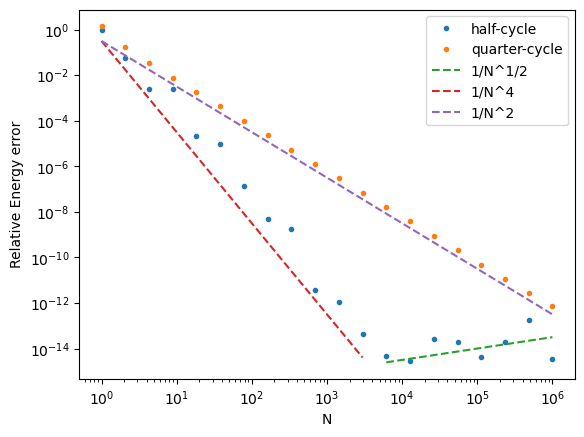

In [167]:
plt.plot(N, E_half, '.', label='half-cycle')
plt.plot(N, E_quarter, '.', label='quarter-cycle')
plt.plot(N[12:], 10**(-16.5)*N[12:]**0.5, linestyle='--', label='1/N^1/2')
plt.plot(N[:12], 10**(-0.5)*N[:12]**-4, linestyle='--', label='1/N^4')
plt.plot(N, 10**(-0.5)*N**-2, linestyle='--', label='1/N^2')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Relative Energy error')
plt.legend()

**Does these scalings agree with the analytic result?**

The analytic results for the leapfrog method show an $h^4$ dependence, which makes sense since we are dealing with a method that accounts for $h^3$, so the error is of the order of $h^4$. Numerically, this seen for the half-cycle in the plot above. 

As the time step becomes smaller (for large N), the dominant erro is from discretization, making Leapfrog behave more like a first-order method, which explains the $1/N^1/2$ behavior in this regime. 



For the quarter cycle, the trend is only downwards in the order of $h^2$. I believe we need a much larger $N$ to see the expected trend, around $10^9$. However, since Leapfrog is a second-order integrator, it makes sense for it to exhibit an error decreasing as $1/N^2$.


# MISSING

## 2. Eigenvalue problem for wave on string

### a. Difference equation for wave on a string

$$ 
A \textbf{f} = \omega^2 b \textbf{f}
$$

To show that the difference equation can be written in this form, where $A$ is a tridiagonal matrix, $b$ is a diagonal matrix and $\textbf{f}$ are eigenfunctions, we want to analyze the wave equation and rewrite it in terms of matrices. 

For a normal mode on a string, the equation is:

$$
\dfrac{\partial^2 \xi}{\partial x^2} = -\omega^2\dfrac{\rho(x)}{T}\xi
$$

We can use the finite-difference method to write a discretized version of this wave equation. Use $\xi_{i,n}$ and for simplicty, assume $T=1$.

$$
\dfrac{\xi_{i,n+1}-2\xi_{i,n}+\xi_{i,n-1}}{\Delta x^2} = -\omega^2\rho_i\xi_{i,n}
$$

Assume a solution of the form $\xi_{i,n} = f_{i,n}$.

$$
f_{i,n+1}-2f_{i,n}+f_{i,n-1} = -\omega^2\dfrac{\rho_i}{\Delta x^2}f_{i,n}
$$

We already get the desired form! On the LHS, the three terms show that we have a tridiagonal matrix; call it $A$. On the RHS, we have a single term corresponding to a diagonal matrix; call it $b$. So, we have:

$$
A \textbf{f} = \omega^2 b \textbf{f}
$$

where
$$
A = \dfrac{1}{\Delta x^2}\begin{bmatrix}
-2 & 1 & \dots & 0 \\
1& -2 & 1 & \dots& 0\\
0 & 1 & -2 & 1 & \dots & 0\\
& & & \ddots \\
\end{bmatrix}
$$

and
$$
b = -\begin{bmatrix}
\rho_1 & 0 & \dots &  \\
0 & \rho_2 & 0 & \dots\\
& & & \ddots \\
& & & & & \rho_n 
\end{bmatrix}
$$


### b. Eigenvalues and eigenvectors

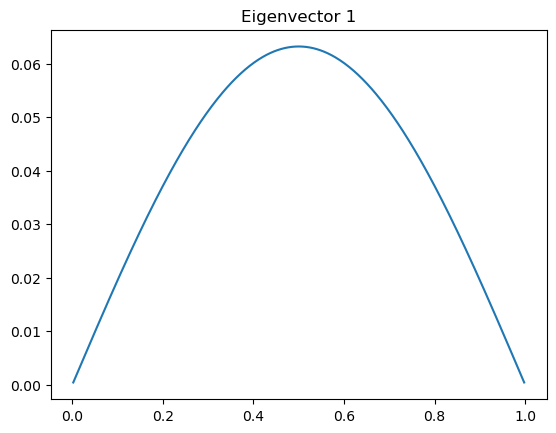

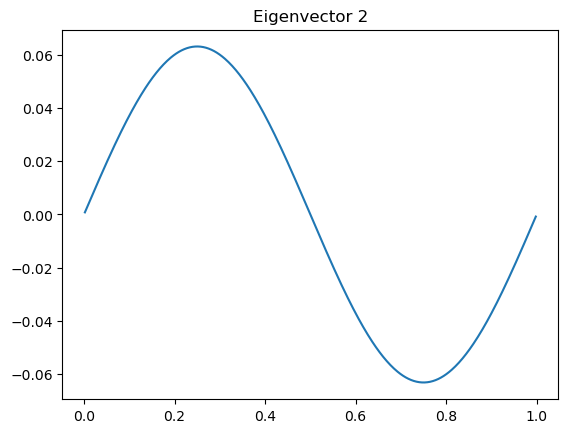

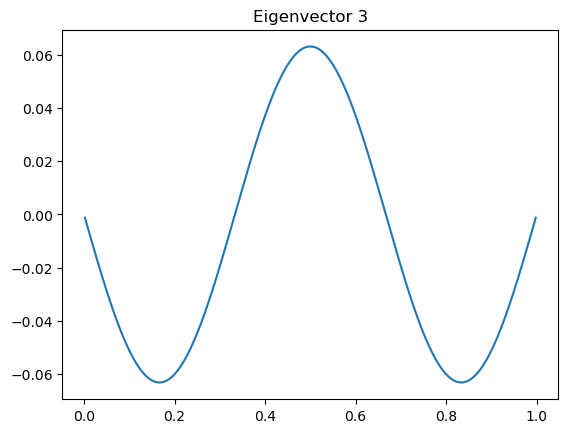

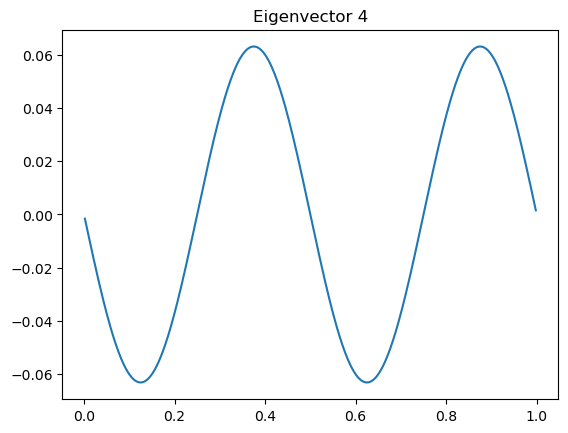

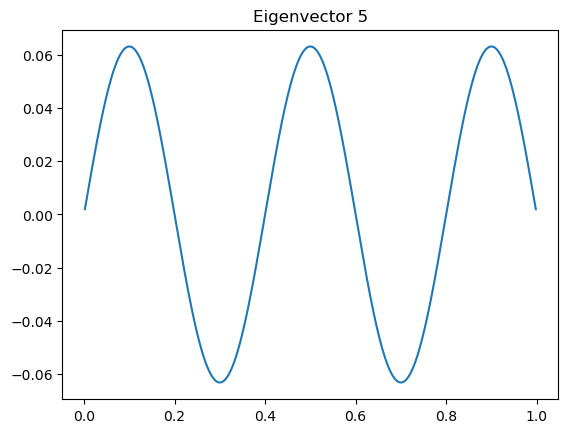

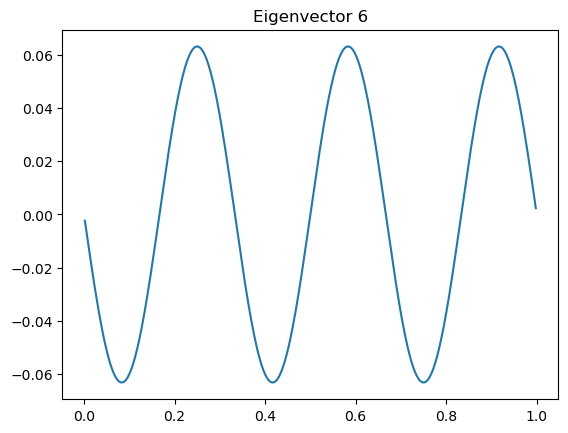

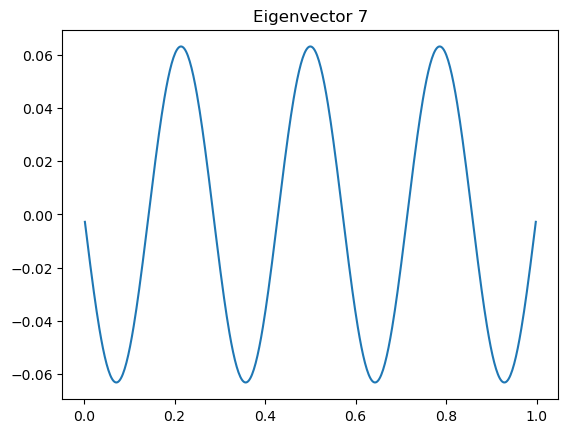

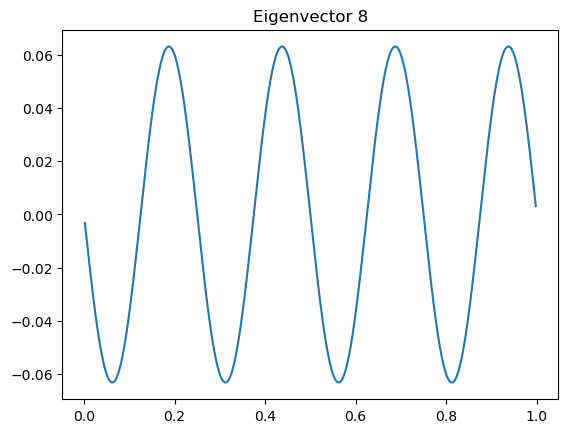

In [227]:
N = 500

def matrix_A_b(n, d='constant'):
    '''Construct tridiagonal matrix A and diagonal matrix b for wave on a 
       string with constant density'''
    dx = 1/(n)

    
    if d!='constant':
        x = np.linspace(0,1,n+2)[1:-1] #no boundaries
        density = 1 + 10*x**2
    else:
        density=1

    main_diag = -2 * np.ones(n) #-2
    off_diag = np.ones(n-1) # 1
    rho_diag = density * np.ones(n)
    
    #construct matrix
    A = (np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1))/dx**2
    
    #construct b
    b = np.diag(rho_diag)
    
    return A, b


A, b = matrix_A_b(N)
#print(A)
#print(b)

eigenvalues, eigenvectors = scipy.linalg.eigh(A, b=b)
#print('First 8 Eigenvalues: ', '\n', eigenvalues[:9], '\n')
#print('First 8 Eigenvectors: ', '\n', eigenvectors[:9], '\n')

#plt.plot(-1*eigenvalues)

#plot
x = np.linspace(0,1, N+2)[1:-1] #without boundaries
#plt.figure(figsize=(10,8))
for i in range(1,9):
    #print(eigenvectors[i,:])
    plt.plot(x, -eigenvectors[:,-i], label=f"Eigenvector {i}")
    plt.title(f"Eigenvector {i}")
    plt.show()
#plt.legend(loc='lower right')

**Compare to shooting method**

From class, we found the following eigenvalues:

**For constant density** 

omega n=0 : 1.00001$\pi$

omega n=1 : 2.00002$\pi$

omega n=2 : 3.00003$\pi$

omega n=3 : 4.00004$\pi$

omega n=4 : 5.00005$\pi$

omega n=5 : 6.00006$\pi$

**Here, we find:**

In [228]:
for i in range(1,9):
    print(f"omega n={i} : ", np.sqrt(-1*eigenvalues)[-8:][-i]/np.pi, 'pi')

omega n=1 :  0.9980023569087929 pi
omega n=2 :  1.995994903224855 pi
omega n=3 :  2.993967828438908 pi
omega n=4 :  3.9919113222420712 pi
omega n=5 :  4.98981557461428 pi
omega n=6 :  5.987670775921574 pi
omega n=7 :  6.985467117011709 pi
omega n=8 :  7.983194789311124 pi


We find the same first 8 eigenvalues as with the shooting method implemented in class and the modes also look like our results from class.


Now, for a string with density $\propto 1+10x^2$

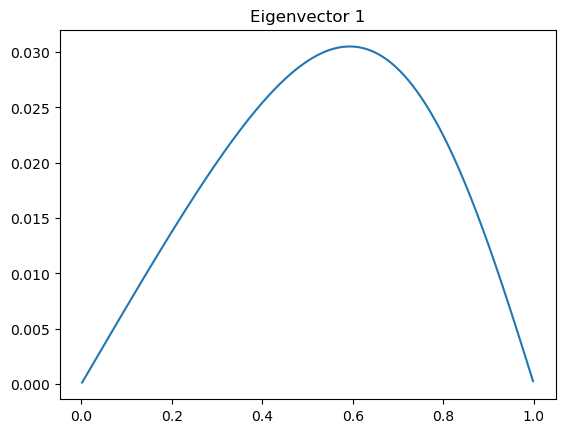

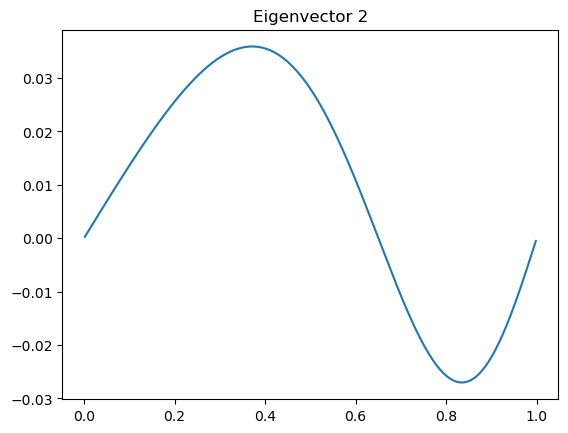

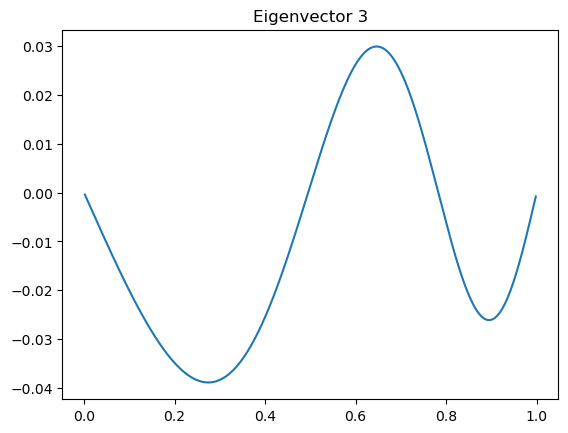

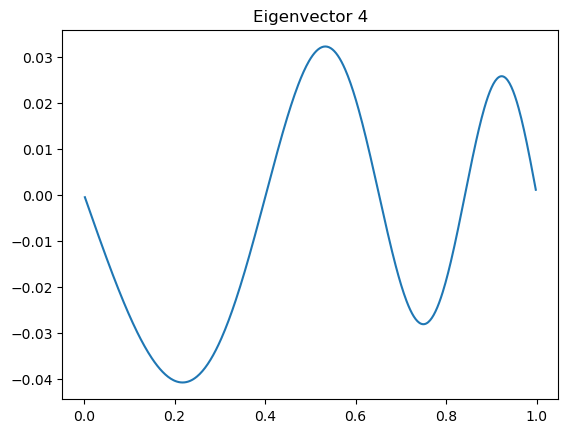

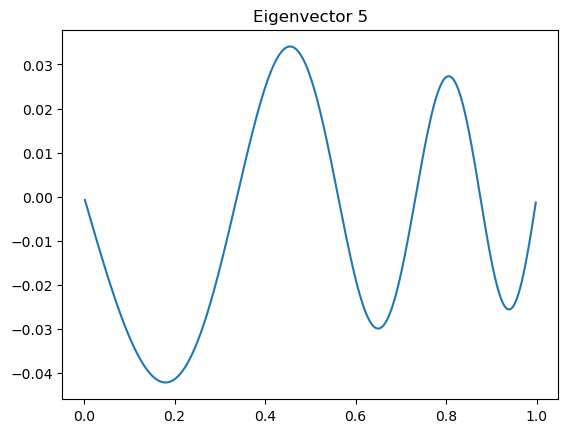

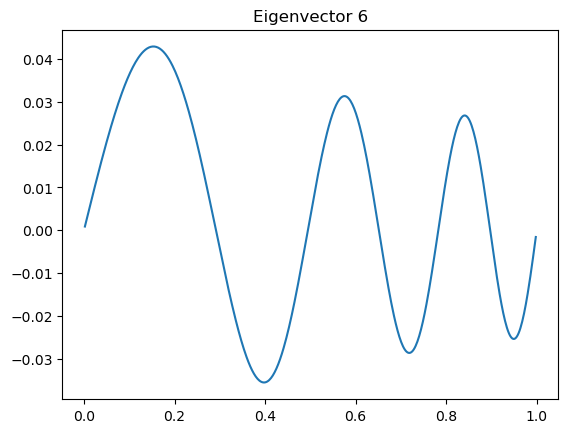

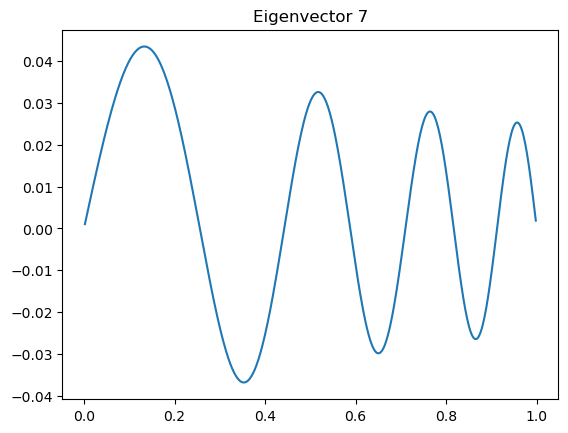

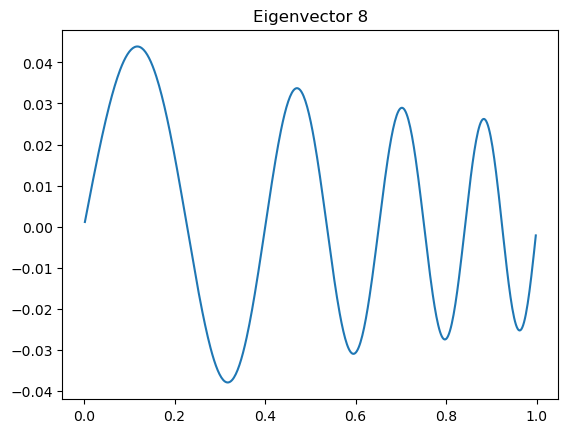

In [229]:
A_d, b_d = matrix_A_b(N, 'not constant')

eigenvalues_d, eigenvectors_d = scipy.linalg.eigh(A_d, b_d)

#plt.figure(figsize=(10,8))
for i in range(1,9):
    #print(eigenvectors[i,:])
    plt.plot(x, -eigenvectors_d[:,-i], label=f"Eigenvector {i}")
    plt.title(f"Eigenvector {i}")
    plt.show()
#plt.legend()

**Compare to shooting method**

From class, we found the following eigenvalues:

**For x-dependent density** 

omega n=0 : 0.493438$\pi$

omega n=1 : 1.01755$\pi$

omega n=2 : 1.53483$\pi$

omega n=3 : 2.0489$\pi$

omega n=4 : 2.56151$\pi$

omega n=5 : 3.0735$\pi$

**Here, we find:**

In [230]:
for i in range(1,9):
    print(f"omega n={i} : ", np.sqrt(-1*eigenvalues_d)[-8:][-i]/np.pi, 'pi')

omega n=1 :  0.49244914603745427 pi
omega n=2 :  1.0155045075042182 pi
omega n=3 :  1.5317289153293865 pi
omega n=4 :  2.0447229800285274 pi
omega n=5 :  2.5562374867582602 pi
omega n=6 :  3.0670922273503023 pi
omega n=7 :  3.577657885722619 pi
omega n=8 :  4.08809293226666 pi


We find the same first 8 eigenvalues as with the shooting method implemented in class and the modes also look like our results from class.

## 3. Leapfrog for electromagnetic wave

In [51]:
#initialize E,B fields
grid_size = 100
N = 1000
a = 1

x = np.linspace(0, grid_size, N)

#Gaussian
sigma = 2.0
Ei = np.exp(-0.5*(x - 6.)**2 / sigma**2)
Bi = np.exp(-0.5*(x - 6.)**2 / sigma**2)

#leapfrog algorithm

def leapfrog(N, n_index, alpha, nsteps, E0, B0, plot=False, boundary=False):
    
    E = np.zeros((nsteps,N))
    B = np.zeros((nsteps,N))
    
    
    #initialize
    E[0] = E0
    B[0] = B0
    
    
    #iterate over time
    for n in range(0, nsteps-1):
        
            if n == 0:
                B[1] = B[0] - alpha*(np.roll(E[0],-1) - np.roll(E[0],1))
                E[1] = E[0] - alpha*(np.roll(B[0],-1) - np.roll(B[0],1))/n_index**2

            else:
                #update magnetic field 
                B[n+1] = B[n-1] - alpha*(np.roll(E[n],-1) - np.roll(E[n],1))
                
                #update electric field
                E[n+1] = E[n-1] - alpha*(np.roll(B[n],-1) - np.roll(B[n],1))/n_index**2
        
        
        #boundary conditions
        #E[n] = np.roll(E[n],1)
        #E[n] = np.roll(E[n],-1)

        
            #visualization every 100 steps
            if plot and n%100==0:
                #print(E)
                plt.plot(x, E[n], label=f"E-field t-step {n}")
                plt.plot(x, B[n], label=f"B-field t-step {n}")
                plt.legend()
                plt.show()
            
    
    
    #plot final result
    plt.plot(x, E[0], label='E initial')
    plt.plot(x, B[0], label='B initial')
    if boundary:
        plt.axvline(x=50, linestyle='--', label='boundary')
        plt.annotate('n = '+str(n_index[0]), xy=(25, 0.5))
        plt.annotate('n = '+str(n_index[-1]), xy=(75, 0.5))
    else:
        plt.annotate('n = '+str(n_index[0]), xy = (40, 0.6))
    plt.plot(x, E[-1], label='E final')
    plt.plot(x, B[-1], label='B final')
    plt.legend()
    plt.show()

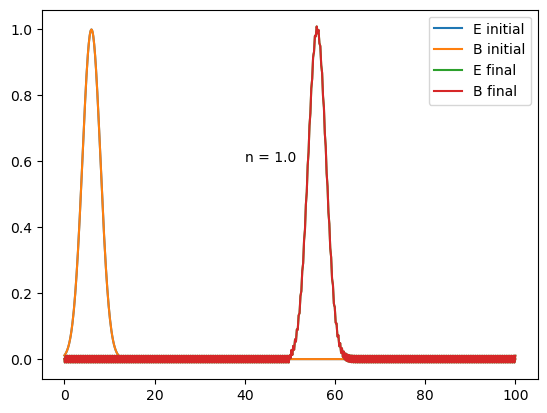

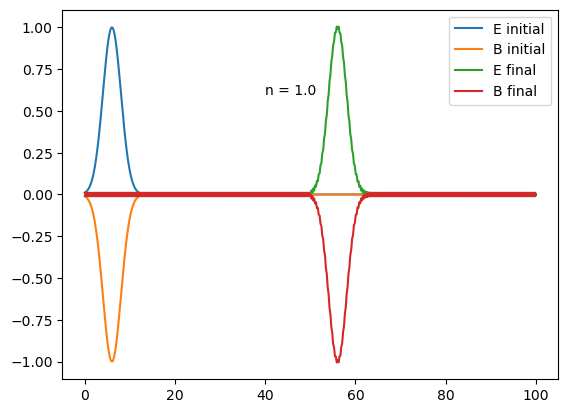

In [47]:
n1 = np.ones(N)
leapfrog(N, n1, a, 500, Ei, Bi)

#now for opossite sign profiles
leapfrog(N, n1, a, 500, Ei, -Bi)

In this case, since the index of refraction is the same everywhere ($n=1$), there is no boundary, and the E and B waves propagate without changing shape. The opposite sign waves make no difference. 

One thing to notice is that there might be a very slight increase in amplitude in the final waves. This is a numerical effect. 

**Now, try a boundary!**

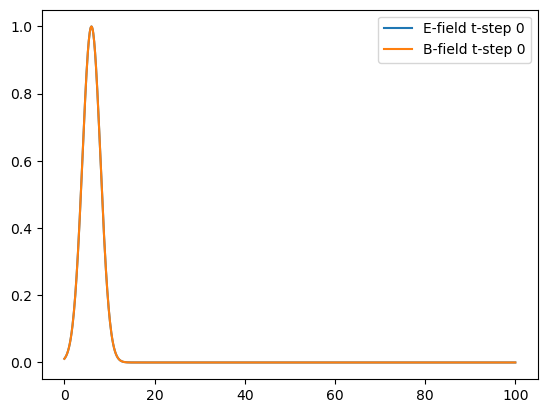

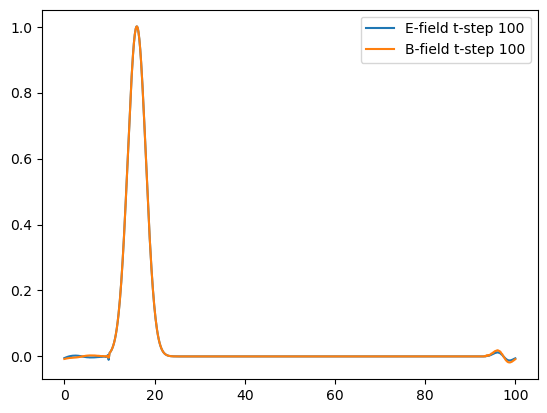

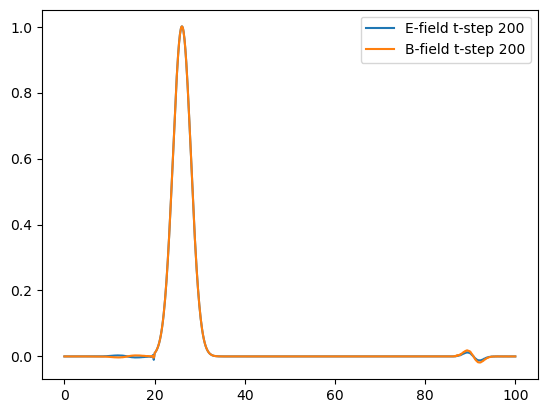

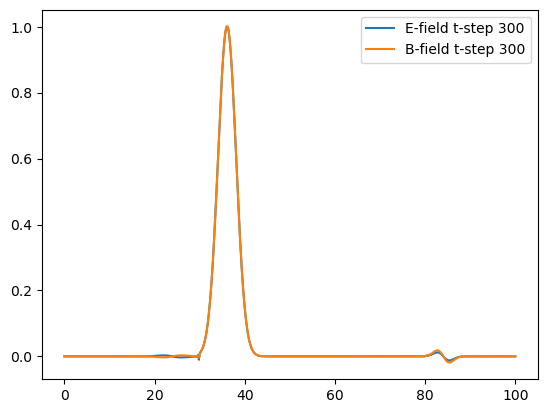

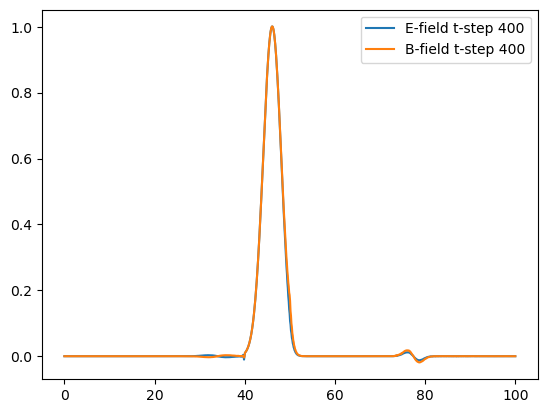

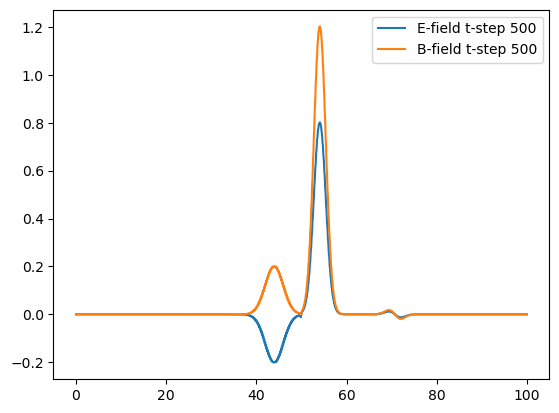

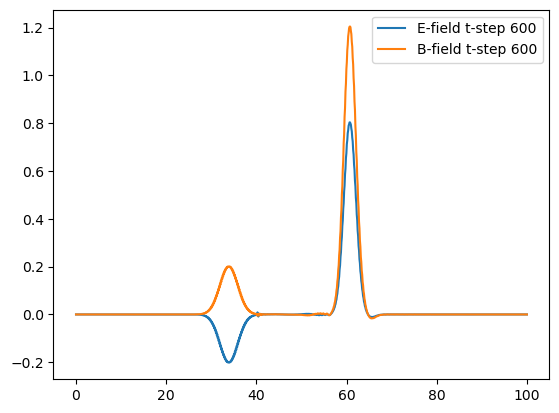

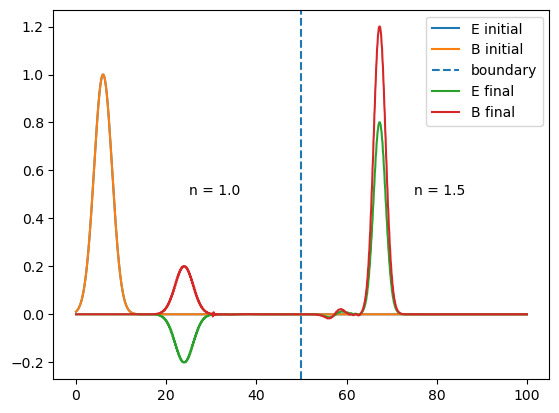

In [52]:
# call algorithm
n_1 = 1.
n_2 = 1.5
n = np.concatenate((n_1*np.ones(N//2),n_2*np.ones(N//2)))


leapfrog(N, n, a, 700, Ei, Bi, plot=True, boundary=True)


As expected, in the presence of a boundary, as the electromagnetic waves propagate accross, we see some reflection and transmission. 

Does the behaviour make sense?

$$
R_E = \dfrac{n_2-n_1}{n_2+n_1} = 0.2
$$

$$
T_E = \dfrac{2n_1}{n_2+n_1} = 0.8
$$

The reflection and transmission coefficients are <1, so it makes sense to see the E wave decreasing in amplitude, as some of it is reflected back. 

As for the B wave, we have the same coefficients but see a slight different behavior. The reflected wave is flipped! Hence, the trasmitted increases in amplitude. This is expected behaviour from waves at a boundary.

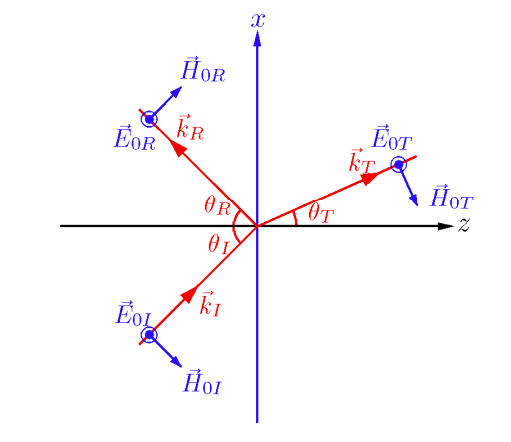

The E wave maintains the same orientation (outward), but the B wave flips. This is observed in the simulation above. 